In [1]:
import numpy as np
import pandas as pd
import functions
from Bio.SeqUtils.ProtParam import ProteinAnalysis


#Solubility wieghted index
weights = {'A': 0.8356956599678218,
 'C': 0.5219207324456876,
 'E': 0.9868660417547442,
 'D': 0.9075983546378998,
 'G': 0.8003827946673535,
 'F': 0.5821934635876957,
 'I': 0.6790449304566072,
 'H': 0.8963977585570367,
 'K': 0.9259165090012061,
 'M': 0.6299964100098959,
 'L': 0.6546922237065839,
 'N': 0.8604957042204235,
 'Q': 0.7895650031998229,
 'P': 0.822104415564934,
 'S': 0.7442464390120463,
 'R': 0.771055152304471,
 'T': 0.8098670971949234,
 'W': 0.6386931894494416,
 'V': 0.7344952876686051,
 'Y': 0.6125581495225544}

%load_ext autoreload
%autoreload 2

#  pET data

In [2]:
pET = pd.read_pickle('results/pET_complete.pkl.gz')
pET.shape


(12216, 5)

In [57]:
pET.head()

Accession  \
pET15 2  BbCD00584211_pET15   
      3  BcCD00331746_pET15   
      4  BcCD00331747_pET15   
      5  BcCD00341383_pET15   
      6  BcCD00591009_pET15   

                                                  Sequence  Class  Solubility  \
pET15 2  ATGGGCCATCACCATCACCATCACAGCCATATGATTTTTGTAACTA...      2           1   
      3  ATGGGCCATCACCATCACCATCACAGCCATATGGATAAAGAGAATC...      1           0   
      4  ATGGGCCATCACCATCACCATCACAGCCATATGGCACATACTACTA...      2           1   
      5  ATGGGCCATCACCATCACCATCACAGCCATATGGATAAAGAGAATC...      1           0   
      6  ATGGGCCATCACCATCACCATCACAGCCATATGAGTTTGAAGGGGA...      2           1   

                                                   Protein  
pET15 2  MGHHHHHHSHMIFVTKLNGDGYYLNPYHIESIEANPDTTILLMNGK...  
      3  MGHHHHHHSHMDKENPRVGDKYITVQKVGKKIFEAEVEILEYDAPH...  
      4  MGHHHHHHSHMAHTTTSMEIFGSPEQVWQLIGGFNSLPDWLPYIPS...  
      5  MGHHHHHHSHMDKENPRVGDKYITVQKVGKKIFEAEVEILEYDAPH...  
      6  MGHHHHHHSHMSLKGKRIGFGFTGSHCTYEEVMPHLEKLIAEGAEV...

In [3]:
#feature analysis

pET['Analysed_seq'] = pET['Protein'].apply(ProteinAnalysis)
pET['Molecular weight'] = pET['Analysed_seq'].apply(lambda x:x.molecular_weight())
pET['Aromaticity'] = pET['Analysed_seq'].apply(lambda x:x.aromaticity())
pET['Instability index'] = pET['Analysed_seq'].apply(lambda x: x.instability_index())
pET['Isoelectric point'] = pET['Analysed_seq'].apply(lambda x:x.isoelectric_point())
pET['Sec_str_fraction'] = pET['Analysed_seq'].apply(lambda x:x.secondary_structure_fraction())
pET['weights'] = pET['Protein'].apply(lambda x:functions.solubility_score(x, weights))
pET['Flexibility_scores'] = pET['Analysed_seq'].apply(lambda x:x.flexibility())
pET['GRAVY'] = pET['Analysed_seq'].apply(lambda x:x.gravy())

#Averaged flexibility
pET['Flexibility'] = pET['Flexibility_scores'].apply(np.mean)

pET['SWI'] = pET['weights'].apply(np.mean)


#separate sec str in helix turn sheets
pET['Helix'] = pET['Sec_str_fraction'].apply(lambda x:x[0])
pET['Turn'] = pET['Sec_str_fraction'].apply(lambda x:x[1])
pET['Sheet'] = pET['Sec_str_fraction'].apply(lambda x:x[2])

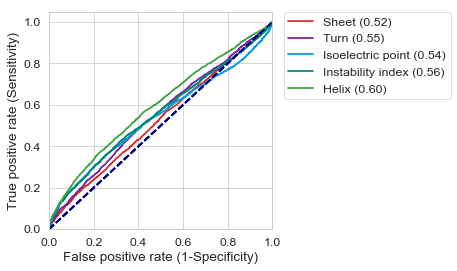

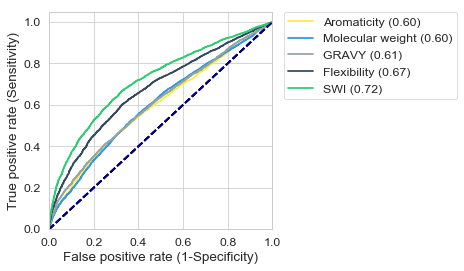

In [20]:
flatui = ["#d32f2f", "#7b1fa2", "#039be5", "#00897b", "#43a047", "#ffeb3b",  "#3498db", "#95a5a6",  "#34495e", "#2ecc71" ]
colors = functions.sns.color_palette(flatui)



df = pET[['Sheet',  'Isoelectric point', 'Turn', 'Instability index' ,  \
          'Aromaticity', 'Helix', 'Molecular weight', 'GRAVY', 'Flexibility', 'SWI', 'Solubility']].copy()


df1 = pET[['Sheet', 'Turn','Isoelectric point', 'Instability index', 'Helix' ]].copy()

#making some columns negative for auc < 0.5
for i, v in enumerate(df1.columns):
    if 'Flexibility' not in v and 'Sheet' not in v and 'SWI' not in v:
        df1[v] = -df1[v]


labels = pET['Solubility'].values
functions.make_roc(df1, labels, output=False, fname='ROC_for_pET_0_SWI.pdf', c=colors[0:5])

##second plot

df2 = pET[['Aromaticity', 'Molecular weight', \
           'GRAVY', 'Flexibility', 'SWI']].copy()


#making some columns negative for auc < 0.5
for i, v in enumerate(df2.columns):
    if 'Flexibility' not in v and 'Sheet' not in v and 'SWI' not in v:
        df2[v] = -df2[v]



functions.make_roc(df2, labels, output=False, fname='ROC_for_pET_1_SWI.pdf', c=colors[5:])


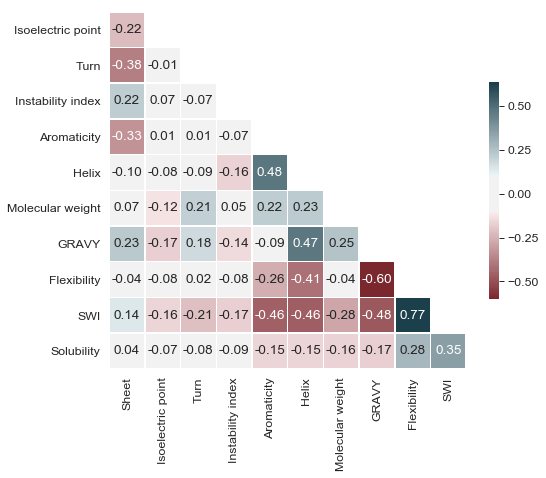

In [5]:
functions.sns.set_context("paper", font_scale=1.4)

functions.corr_heatmap(df, squared=False, output=True, fname='Heatmap_for_pET_with_SWI.pdf',\
                       )


In [21]:
#correlations
from scipy.stats import spearmanr


df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in df.columns:
    for y in df.columns:
        corr1 = spearmanr(df[x], df[y])
        df_corr.loc[x,y] = corr1[0]
        df_p.loc[x,y] = corr1[1]



In [23]:
print('Correlations')
df_corr


Correlations


,Sheet,Isoelectric point,Turn,Instability index,Aromaticity,Helix,Molecular weight,GRAVY,Flexibility,SWI,Solubility
Sheet,1.000000,-0.222060,-0.375104,0.220627,-0.328068,-0.097355,0.070636,0.232137,-0.041549,0.143317,0.040284
Isoelectric point,-0.222060,1.000000,-0.010108,0.072233,0.009231,-0.082686,-0.124552,-0.171168,-0.083467,-0.158965,-0.065772
Turn,-0.375104,-0.010108,1.000000,-0.073050,0.010417,-0.089198,0.210953,0.182721,0.024328,-0.211602,-0.080815
Instability index,0.220627,0.072233,-0.073050,1.000000,-0.072715,-0.159392,0.045370,-0.143305,-0.076660,-0.172905,-0.090254
Aromaticity,-0.328068,0.009231,0.010417,-0.072715,1.000000,0.476667,0.222074,-0.090969,-0.259083,-0.455687,-0.154726
Helix,-0.097355,-0.082686,-0.089198,-0.159392,0.476667,1.000000,0.226637,0.470759,-0.409018,-0.460267,-0.154866
Molecular weight,0.070636,-0.124552,0.210953,0.045370,0.222074,0.226637,1.000000,0.249705,-0.037168,-0.276888,-0.162451
GRAVY,0.232137,-0.171168,0.182721,-0.143305,-0.090969,0.470759,0.249705,1.000000,-0.600141,-0.477966,-0.170855
Flexibility,-0.041549,-0.083467,0.024328,-0.076660,-0.259083,-0.409018,-0.037168,-0.600141,1.000000,0.773422,0.280697
SWI,0.143317,-0.158965,-0.211602,-0.172905,-0.455687,-0.460267,-0.276888,-0.477966,0.773422,1.000000,0.354597


In [24]:
print('Bonferroni corrected p values')
#correction for p-values
bonferroni_ = len(df_corr)*(len(df_corr)-1)/2
df_p*bonferroni_

Bonferroni corrected p values


,Sheet,Isoelectric point,Turn,Instability index,Aromaticity,Helix,Molecular weight,GRAVY,Flexibility,SWI,Solubility
Sheet,0.000000e+00,1.360251e-134,0.000000e+00,8.055313e-133,1.158844e-302,2.234832e-25,2.997351e-13,2.066671e-147,2.394248e-04,2.495143e-55,4.640388e-04
Isoelectric point,1.360251e-134,0.000000e+00,1.451603e+01,7.226754e-14,1.692078e+01,3.024908e-18,1.081815e-41,3.139424e-79,1.350046e-18,3.256456e-68,1.882019e-11
Turn,0.000000e+00,1.451603e+01,0.000000e+00,3.450698e-14,1.372876e+01,2.870992e-21,3.466726e-121,1.878549e-90,3.941532e-01,5.986762e-122,2.029201e-17
Instability index,8.055313e-133,7.226754e-14,3.450698e-14,0.000000e+00,4.678082e-14,1.388138e-68,2.891421e-05,2.551309e-55,1.191648e-15,7.228583e-81,8.835143e-22
Aromaticity,1.158844e-302,1.692078e+01,1.372876e+01,4.678082e-14,0.000000e+00,0.000000e+00,1.306411e-134,3.945122e-22,7.937320e-185,0.000000e+00,1.382944e-64
Helix,2.234832e-25,3.024908e-18,2.870992e-21,1.388138e-68,0.000000e+00,0.000000e+00,2.449525e-140,0.000000e+00,0.000000e+00,0.000000e+00,1.053179e-64
Molecular weight,2.997351e-13,1.081815e-41,3.466726e-121,2.891421e-05,1.306411e-134,2.449525e-140,0.000000e+00,2.796242e-171,2.184998e-03,3.979065e-212,2.841645e-71
GRAVY,2.066671e-147,3.139424e-79,1.878549e-90,2.551309e-55,3.945122e-22,0.000000e+00,2.796242e-171,0.000000e+00,0.000000e+00,0.000000e+00,6.171375e-79
Flexibility,2.394248e-04,1.350046e-18,3.941532e-01,1.191648e-15,7.937320e-185,0.000000e+00,2.184998e-03,0.000000e+00,0.000000e+00,0.000000e+00,3.067123e-218
SWI,2.495143e-55,3.256456e-68,5.986762e-122,7.228583e-81,0.000000e+00,0.000000e+00,3.979065e-212,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [9]:
pET.to_pickle('results/pET_all_analysis.pkl.gz')

# E. coli data

In [10]:
#For ecoli data
ecoli_w3110 = pd.read_pickle('results/ecoli.pkl.gz', compression='infer')
ecoli_w3110.shape

(3198, 5)

In [11]:
ecoli_w3110.head()

,Accession,Sequence,ECK number,JW,Solubility(%)
2,JW0002 thrB ECK0003,MRGSHHHHHHTDPALRAMVKVYAPASSANMSVGFDVLGAAVTPVDG...,ECK0003,JW0002,32.0
3,JW0003 thrC ECK0004,MRGSHHHHHHTDPALRAMKLYNLKDHNEQVSFAQAVTQGLGKNQGL...,ECK0004,JW0003,18.0
4,JW0004 yaaX ECK0005,MRGSHHHHHHTDPALRAMKKMQSIVLALSLVLVAPMAAQAAEITLV...,ECK0005,JW0004,78.0
5,JW0005 yaaA ECK0006,MRGSHHHHHHTDPALRAMLILISPAKTLDYQSPLTTTRYTLPELLD...,ECK0006,JW0005,7.0
7,JW0007 talB ECK0008,MRGSHHHHHHTDPALRAMTDKLTSLRQYTTVVADTGDIAAMKLYQP...,ECK0008,JW0007,85.0


In [12]:
ecoli_w3110['Analysed_seq'] = ecoli_w3110['Sequence'].apply(ProteinAnalysis)

ecoli_w3110['Molecular weight'] = ecoli_w3110['Analysed_seq'].apply(lambda x:x.molecular_weight())
ecoli_w3110['Aromaticity'] = ecoli_w3110['Analysed_seq'].apply(lambda x:x.aromaticity())
ecoli_w3110['Instability index'] = ecoli_w3110['Analysed_seq'].apply(lambda x:x.instability_index())
ecoli_w3110['Isoelectric point'] = ecoli_w3110['Analysed_seq'].apply(lambda x:x.isoelectric_point())
ecoli_w3110['Sec_str_fraction'] = ecoli_w3110['Analysed_seq'].apply(lambda x:x.secondary_structure_fraction())
ecoli_w3110['Flex'] = ecoli_w3110['Analysed_seq'].apply(lambda x:x.flexibility())
ecoli_w3110['GRAVY'] = ecoli_w3110['Analysed_seq'].apply(lambda x:x.gravy())


ecoli_w3110['weights'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, weights))
ecoli_w3110['SWI'] = ecoli_w3110['weights'].apply(np.mean)



ecoli_w3110['Flexibility'] = ecoli_w3110['Flex'].apply(np.mean)
#separate sec str in helix turn sheets
ecoli_w3110['Helix'] = ecoli_w3110['Sec_str_fraction'].apply(lambda x:x[0])
ecoli_w3110['Turn'] = ecoli_w3110['Sec_str_fraction'].apply(lambda x:x[1])
ecoli_w3110['Sheet'] = ecoli_w3110['Sec_str_fraction'].apply(lambda x:x[2])

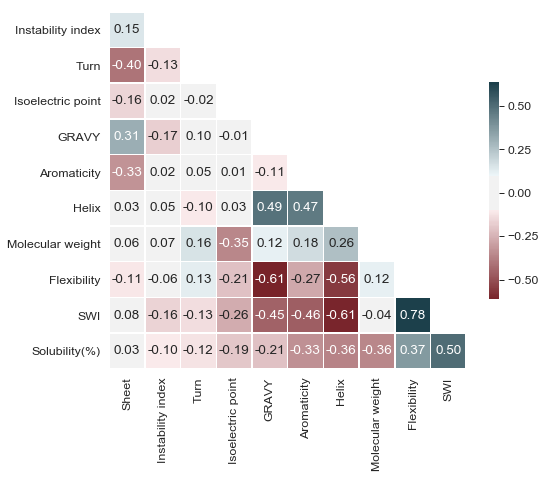

In [13]:
d = ecoli_w3110[['Sheet', 'Instability index', 'Turn', 'Isoelectric point', \
                 'GRAVY', 'Aromaticity', 'Helix',  \
                  'Molecular weight',  'Flexibility', 'SWI',\
                 'Solubility(%)']]

functions.corr_heatmap(d, squared=False, output=True,\
                       fname='Heatmap_for_Ecoli_features.pdf')

In [14]:
#correlations
from scipy.stats import spearmanr


df_corr_ecoli = pd.DataFrame() # Correlation matrix
df_p_ecoli = pd.DataFrame()  # Matrix of p-values
for x in d.columns:
    for y in d.columns:
        corr1 = spearmanr(d[x], d[y])
        df_corr_ecoli.loc[x,y] = corr1[0]
        df_p_ecoli.loc[x,y] = corr1[1]



In [15]:
print('Correlations')
df_corr_ecoli

Correlations


,Sheet,Instability index,Turn,Isoelectric point,GRAVY,Aromaticity,Helix,Molecular weight,Flexibility,SWI,Solubility(%)
Sheet,1.000000,0.146456,-0.403058,-0.156209,0.309439,-0.326514,0.027550,0.059391,-0.112851,0.080779,0.027396
Instability index,0.146456,1.000000,-0.134142,0.015775,-0.169240,0.015088,0.054600,0.069486,-0.057118,-0.159166,-0.099881
Turn,-0.403058,-0.134142,1.000000,-0.018457,0.096262,0.047374,-0.103803,0.158678,0.126597,-0.133176,-0.122414
Isoelectric point,-0.156209,0.015775,-0.018457,1.000000,-0.013594,0.005004,0.028062,-0.353713,-0.207243,-0.263824,-0.192862
GRAVY,0.309439,-0.169240,0.096262,-0.013594,1.000000,-0.107626,0.487898,0.118364,-0.612059,-0.454825,-0.208084
Aromaticity,-0.326514,0.015088,0.047374,0.005004,-0.107626,1.000000,0.468139,0.179587,-0.272430,-0.464801,-0.328931
Helix,0.027550,0.054600,-0.103803,0.028062,0.487898,0.468139,1.000000,0.260863,-0.557496,-0.605712,-0.364232
Molecular weight,0.059391,0.069486,0.158678,-0.353713,0.118364,0.179587,0.260863,1.000000,0.117507,-0.043265,-0.357656
Flexibility,-0.112851,-0.057118,0.126597,-0.207243,-0.612059,-0.272430,-0.557496,0.117507,1.000000,0.779539,0.372535
SWI,0.080779,-0.159166,-0.133176,-0.263824,-0.454825,-0.464801,-0.605712,-0.043265,0.779539,1.000000,0.504099


In [16]:
print('Bonferroni corrected p values')

#correction for p-values
bonferroni_ = len(df_corr_ecoli)*(len(df_corr_ecoli)-1)/2
df_p*bonferroni_

Bonferroni corrected p values


,Sheet,Isoelectric point,Turn,Instability index,Aromaticity,Helix,Molecular weight,GRAVY,Flexibility,SWI,Solubility
Sheet,0.000000e+00,1.360251e-134,0.000000e+00,8.055313e-133,1.158844e-302,2.234832e-25,2.997351e-13,2.066671e-147,2.394248e-04,2.495143e-55,4.640388e-04
Isoelectric point,1.360251e-134,0.000000e+00,1.451603e+01,7.226754e-14,1.692078e+01,3.024908e-18,1.081815e-41,3.139424e-79,1.350046e-18,3.256456e-68,1.882019e-11
Turn,0.000000e+00,1.451603e+01,0.000000e+00,3.450698e-14,1.372876e+01,2.870992e-21,3.466726e-121,1.878549e-90,3.941532e-01,5.986762e-122,2.029201e-17
Instability index,8.055313e-133,7.226754e-14,3.450698e-14,0.000000e+00,4.678082e-14,1.388138e-68,2.891421e-05,2.551309e-55,1.191648e-15,7.228583e-81,8.835143e-22
Aromaticity,1.158844e-302,1.692078e+01,1.372876e+01,4.678082e-14,0.000000e+00,0.000000e+00,1.306411e-134,3.945122e-22,7.937320e-185,0.000000e+00,1.382944e-64
Helix,2.234832e-25,3.024908e-18,2.870992e-21,1.388138e-68,0.000000e+00,0.000000e+00,2.449525e-140,0.000000e+00,0.000000e+00,0.000000e+00,1.053179e-64
Molecular weight,2.997351e-13,1.081815e-41,3.466726e-121,2.891421e-05,1.306411e-134,2.449525e-140,0.000000e+00,2.796242e-171,2.184998e-03,3.979065e-212,2.841645e-71
GRAVY,2.066671e-147,3.139424e-79,1.878549e-90,2.551309e-55,3.945122e-22,0.000000e+00,2.796242e-171,0.000000e+00,0.000000e+00,0.000000e+00,6.171375e-79
Flexibility,2.394248e-04,1.350046e-18,3.941532e-01,1.191648e-15,7.937320e-185,0.000000e+00,2.184998e-03,0.000000e+00,0.000000e+00,0.000000e+00,3.067123e-218
SWI,2.495143e-55,3.256456e-68,5.986762e-122,7.228583e-81,0.000000e+00,0.000000e+00,3.979065e-212,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [17]:
ecoli_w3110.to_pickle('results/ecoli_all_analysis.pkl.gz')